## Matching characteristics of the real data

The attributes of the simulation are provided by the user in a configuration file.  These include:
* Quantities you might read from the headers of the real data, or in reports that the Detector Characterization Lab (DCL) have provided:
 * time steps between each sampled frame (DT)
 * quantum efficiency (QE)
* Quantities drawn from `solid-waffle` fits:
 * gain in e/DN (GAIN)
 * illumination in terms of current in e (ILLUMINATION)
 * linear interpixel capacitance coefficient, $\alpha$ (L_IPC)
 * brighter-fatter coefficients (currently hard-coded in `detector_functions.py`)
 
It may be useful to make some adjustments specific to the data format, for example the FORMAT, but the code currently only supports FORMAT 1. FORMAT is described in detail early in `ScriptInformation.txt`.  Note that many of the recent H4RG-10 data provided by the DCL (e.g., SCA 20829) have FORMAT 4.  In principle, `solid-waffle` results should not care which format is used so long as you specify the correct format in the config file.

## Matching characteristics of the real data

The attributes of the simulation are provided by the user in a configuration file.  These include:
* Quantities you might read from the headers of the real data, or in reports that the Detector Characterization Lab (DCL) have provided:
 * time steps between each sampled frame (DT)
 * quantum efficiency (QE)
* Quantities drawn from `solid-waffle` fits:
 * gain in e/DN (GAIN)
 * illumination in terms of current in e (ILLUMINATION)
 * linear interpixel capacitance coefficient, $\alpha$ (L_IPC)
 * brighter-fatter coefficients (currently hard-coded in `detector_functions.py`)
 
It may be useful to make some adjustments specific to the data format, for example the FORMAT, but the code currently only supports FORMAT 1. FORMAT is described in detail early in `ScriptInformation.txt`.  Note that many of the recent H4RG-10 data provided by the DCL (e.g., SCA 20829) have FORMAT 4.  In principle, `solid-waffle` results should not care which format is used so long as you specify the correct format in the config file.

In [2]:
# Comparing simulated flats and darks with real ones
import fitsio
import numpy as np
import sys
sys.path.append("../")
import pyirc
# Paths are at the Ohio Supercomputer Center
simdir='/fs/project/PCON0003/ami/simulated_detector/'
datadir='/fs/scratch/PCON0003/cond0007/SCA20829/'
simflat='%s/mar11_sca20829_vissim_diffbfe_flat1.fits'%simdir
#simflat='%s/vissim_bfe_ipc_offdiagp2_flat1.fits'%simdir
#simflat='%s/sca20829_irsim_diffbfe_flat1.fits'%simdir
#simdark='%s/vissim_bfe_ipc_offdiagp2_dark1.fits'%simdir
#simdark='%s/sca20829_irsim_diffbfe_dark2.fits'%simdir
#simdark='%s/sca20829_irsim_diffbfe_dark5_TESTWAVEMODE.fits'%simdir
simdark='%s/mar11_sca20829_vissim_diffbfe_dark1.fits'%simdir
realflat='%s/20191018_95K_1p1m0p1_ch3_1400nm_gr3_filt5_shutter_open_20829_001.fits'%datadir
realdark='%s/20191018_95K_1p1m0p1_ch0_1400nm_gr3_filt5_shutter_closed_20829_001.fits'%datadir
# More efficient to use pyirc tools to do this by superpixel because reading in the whole
# datacube takes up a lot of memory

# Use load_segment from pyirc
# Function to load an image segment
#
# filename = name of the source FITS file
# formatpars = integer describing which type of format to use
#     format 1: H4RG, all data in a single HDU, ramp slope positive (ex. DCL H4RG-18237 data)
# xyrange = list [xmin,xmax,ymin,ymax] (first row/col are zero) -- EXcluding xmax and ymax!
# tslices = list of time slices to use (first is *1*)
# verbose = True or False (use True only for de-bugging)
#
# Returns a 3D array of dimension number tslices, ymax-ymin, xmax-xmin
#
formatpars=4
xyrange=[0,4096,0,4096] # Remember that the first four rows and columns are reference pixels
tslices=[1, 2, 3, 4, 5, 10,20,30,35,40,50,60]
# Recommended True (False defaults to astropy tools, which work but are slow because of the way this script works)
use_fitsio = True

# Get dimensions of output cube
nxuse = xyrange[1]-xyrange[0]
nyuse = xyrange[3]-xyrange[2]
ntslice_use = len(tslices)
realdarkcube = np.zeros((ntslice_use, nyuse, nxuse))

realdarkcube=pyirc.load_segment(realdark, formatpars, xyrange, tslices, verbose=True)

Reading: /fs/scratch/PCON0003/cond0007/SCA20829//20191018_95K_1p1m0p1_ch0_1400nm_gr3_filt5_shutter_closed_20829_001.fits


Some of the useful values we can get from the `solid-waffle` runs on SCA 20829 described in Freudenburg, Givans et al. (https://arxiv.org/pdf/2003.05978.pdf) Table 4 on page 26 of the arxiv pdf version.  These are all for the infrared data.

charge Q =  3051.5 e  Note that to get the `ILLUMINATION` which is e/s, we divide Q by t=2.75s to get 1109.64 e/s

gain g = 1.7285 e/DN

alpha =  0.01379 (we'll take the average and assume symmetry for now)

$\beta_2$g = 2.8147E6 (DN$^{-1})

$\beta_3$g$^2$ = -1.0841E10 (DN$^{-2})

$\beta_4$g$^2$ = 2.3025E10 (DN$^{-3})

I also took a glance at the acceptance test reports available from the detector characterization lab (linked from internal STScI webserver) for 20828 and 20663, and the QE looked to be around 95\% for 20663 and higher, maybe 99\% for 20828.  I didn't see a report for 20829, so let's just go with QE=95\% for the simulation config.  The dark current for 20828 is 0.007 e/s and 0.005 e/s for 20663, so let's go with 0.007 e/s.

One useful thing is to know where the real dark signal level is at and how it compares to the simulated dark signal level

In [3]:
# Find where the real dark signal level is
print(realdarkcube.shape)

# Print out the means, subtract them from 65535 as format 4 signals decrease with time increasing
# and currently the simulated flats will only simulate format 1 with increasing signals with time increasing
for tdx in range(len(tslices)):
    print(np.mean(realdarkcube[tdx,4:-4, 4:-4]))


(12, 4096, 4096)
53927.357412069025
53927.42432333813
53927.82983667055
53928.51856957598
53928.35626479199
53928.26437432263
53929.79686039949
53928.86373193606
53929.200358322865
53929.99635567658
53929.430609935145
53929.99498598112


In [4]:
# Compare to the simulated dark signal level
simdarkcube=np.zeros_like(realdarkcube)
simdarkcube=pyirc.load_segment(simflat, 1, xyrange, tslices, verbose=True)
print(simdarkcube.shape)
# Print out the means
for tdx in range(len(tslices)):
    print(np.mean(simdarkcube[tdx,4:-4, 4:-4]))


Reading: /fs/project/PCON0003/ami/simulated_detector//mar11_sca20829_vissim_diffbfe_flat1.fits
(12, 4096, 4096)
53154.824472119726
51477.67864263598
49800.550740724604
48123.41091947076
46446.280177580506
38060.55486034253
21289.15116567128
4517.780230417603
0.0
0.0
0.0
0.0


The simulated darks seem a bit different in terms of signal level for the first comparisons I am making: 53927.4 in the real dark and 65477.6 in the simulated dark. This can be adjusted by tuning
```RESET_E: 1.0e2```
in the configuration file that gets passed to the ```simulate_flat.py``` script.

## Finding the BFE kernel values from the `solid-waffle` IR and visible runs
This draws from the code Anna wrote in `plots_fiducial.ipynb` to read in the BFE kernels from the IR and visible outputs.  Then we would like to average the values over superpixels to get a rough input for the simulations.

In [5]:
np.set_printoptions(suppress=True),
outputdir='/users/PCON0003/cond0088/Projects/detectors/sw_outputs/PaperIV_chargediffusion'
ir_file = open('%s/chris_20829vis_fid1_summary.txt'%outputdir)
ir_data = np.loadtxt(ir_file)
ir_file.close()
bfe = np.ma.masked_where(ir_data[:,13:38]==0, ir_data[:,13:38])
out_bfe_arr = bfe.reshape(bfe.shape[0],5,5)
avg_bfe_arr = np.mean(out_bfe_arr,axis=0)
print("sum of avg bfe:", avg_bfe_arr.sum())
# Print in ppm/e for ease of visual comparison
print(np.round(1.E6*avg_bfe_arr,decimals=6))
# Check also how much it deviates from summing to zero
print(np.round(1.E6*avg_bfe_arr,decimals=6).sum())

vis_file = open('%s/chris_20829vis_fid1_visinfo.txt'%outputdir)
vis_data = np.loadtxt(vis_file)
vis_file.close()
vis_bfe = np.ma.masked_where(vis_data[:,:25]==0, vis_data[:,:25])
out_visbfe_arr = vis_bfe.reshape(vis_bfe.shape[0],5,5)
avg_visbfe_arr = np.mean(out_visbfe_arr,axis=0)
print("sum of avg bfe:",avg_visbfe_arr.sum())
print(np.round(1.E6*avg_visbfe_arr,decimals=6))
print(np.round(1.E6*avg_visbfe_arr,decimals=6).sum())
"""ir_cols = ['superX','superY','goodpix','raw_gain','gain_alpha','gain_alphabeta',
                'alphaH','alphaV','betaNL','q_per_t','alphaD','cH','cV',
                'bfe_IR(-2,-2)','bfe_IR(-1,-2)','bfe_IR(0,-2)','bfe_IR(1,-2)','bfe_IR(2,-2)',
                'bfe_IR(-2,-1)', 'bfe_IR(-1,-1)','bfe_IR(0,-1)','bfe_IR(1,-1)','bfe_IR(2,-1)',
                'bfe_IR(-2,0)','bfe_IR(-1,0)','bfe_IR(0,0)','bfe_IR(1,0)','bfe_IR(2,0)',
                'bfe_IR(-2,1)','bfe_IR(-1,1)','bfe_IR(0,1)','bfe_IR(1,1)','bfe_IR(2,1)',
                'bfe_IR(-2,2)','bfe_IR(-1,2)','bfe_IR(0,2)','bfe_IR(1,2)','bfe_IR(2,2)',
                't_intercept','beta2','beta3','beta4']"""
# double-checking how np.reshape maps to indices
test = np.array(('-2,-2','-1,-2','0,-2','1,-2','2,-2','-2,-1','-1,-1','0,-1','1,-1','2,-1','-2,0','-1,0','0,0','1,0','2,0','-2,1','-1,1','0,1','1,1','2,1','-2,2','-1,2','0,2','1,2','2,2'))
print(test.reshape((5,5)))

sum of avg bfe: 3.1714177103068526e-07
[[ 0.002428  0.018179  0.034335  0.017008  0.005557]
 [ 0.010687  0.103002  0.389114  0.11482   0.009735]
 [ 0.023426  0.362651 -1.971387  0.385713  0.031503]
 [ 0.015851  0.118116  0.440877  0.110673  0.010928]
 [ 0.006783  0.016524  0.031761  0.02166   0.007196]]
0.31714
sum of avg bfe: -2.672150955848493e-08
[[ 0.000223 -0.001887  0.012268  0.0083   -0.006043]
 [ 0.010682  0.098918  0.379619  0.111994  0.022616]
 [ 0.016828  0.342355 -2.08724   0.36191   0.01779 ]
 [ 0.00773   0.105579  0.422182  0.100917  0.008805]
 [ 0.003546 -0.000805  0.028231  0.00376   0.004999]]
-0.026723000000000028
[['-2,-2' '-1,-2' '0,-2' '1,-2' '2,-2']
 ['-2,-1' '-1,-1' '0,-1' '1,-1' '2,-1']
 ['-2,0' '-1,0' '0,0' '1,0' '2,0']
 ['-2,1' '-1,1' '0,1' '1,1' '2,1']
 ['-2,2' '-1,2' '0,2' '1,2' '2,2']]


In [6]:
#This cell is me messing around and trying to get a BFE kernel that sums to 0
#input_bfe_ir = avg_bfe_arr - avg_bfe_arr.sum()
input_bfe_ir = np.round(1.E6*avg_bfe_arr,decimals=4)-np.round(1.E6*avg_bfe_arr,decimals=4).sum()/25.
print(np.round(input_bfe_ir,decimals=4).sum())
print(repr(np.round(input_bfe_ir,decimals=4)))
tmp=np.array([[ 0.0016,  0.0128,  0.02  ,  0.0166, -0.002 ],
        [-0.0039,  0.1   ,  0.4343,  0.1068,  0.0044],
        [ 0.0077,  0.3598, -2.0356,  0.3797,  0.0157],
        [-0.0047,  0.0835,  0.3807,  0.1068, -0.0083],
        [-0.0048,  0.0051,  0.0297, -0.0023, -0.0036]])

print("sum of the above array: ",tmp.sum())
input_bfe_vis = np.round(1.E6*avg_visbfe_arr,decimals=6)-np.round(1.E6*avg_visbfe_arr,decimals=6).sum()/25.
print("sum of input_bfe_vis, defined above: ",input_bfe_vis.sum())
print(repr(np.round(input_bfe_vis,decimals=4)))
test=np.array([[ 0.0013, -0.0008,  0.0133,  0.0094, -0.005 ],
        [ 0.0118,  0.1   ,  0.3807,  0.1131,  0.0237],
        [ 0.0179,  0.3434, -3.0862,  0.363 ,  0.0189],
        [ 0.0088,  0.1066,  0.4233,  0.102 ,  0.0099],
        [ 0.0046,  0.0003,  0.0293,  0.0048,  0.0061]])
test2=test-test.sum()/25.
print(repr(np.round(test2,decimals=4)))
print("sum of the above array: ",np.round(test2,decimals=4).sum())
test3=np.array([[ 0.0413,  0.0392,  0.0533,  0.0494,  0.035 ],
       [ 0.0518,  0.14  ,  0.4207,  0.1531,  0.0637],
       [ 0.0579,  0.3834, -3.0462,  0.403 ,  0.0589],
       [ 0.0488,  0.1466,  0.4633,  0.142 ,  0.0499],
       [ 0.0446,  0.0403,  0.0693,  0.0448,  0.0459]])
# triple-checking...
test3.sum()

-0.0003000000000001283
masked_array(
  data=[[-0.0103,  0.0055,  0.0216,  0.0043, -0.0071],
        [-0.002 ,  0.0903,  0.3764,  0.1021, -0.003 ],
        [ 0.0107,  0.35  , -1.9841,  0.373 ,  0.0188],
        [ 0.0032,  0.1054,  0.4282,  0.098 , -0.0018],
        [-0.0059,  0.0038,  0.0191,  0.009 , -0.0055]],
  mask=False,
  fill_value=1e+20)
sum of the above array:  2.697495005143935e-16
sum of input_bfe_vis, defined above:  -2.255140518769849e-16
masked_array(
  data=[[ 0.0013, -0.0008,  0.0133,  0.0094, -0.005 ],
        [ 0.0118,  0.1   ,  0.3807,  0.1131,  0.0237],
        [ 0.0179,  0.3434, -2.0862,  0.363 ,  0.0189],
        [ 0.0088,  0.1066,  0.4233,  0.102 ,  0.0099],
        [ 0.0046,  0.0003,  0.0293,  0.0048,  0.0061]],
  mask=False,
  fill_value=1e+20)
array([[ 0.0413,  0.0392,  0.0533,  0.0494,  0.035 ],
       [ 0.0518,  0.14  ,  0.4207,  0.1531,  0.0637],
       [ 0.0579,  0.3834, -3.0462,  0.403 ,  0.0589],
       [ 0.0488,  0.1466,  0.4633,  0.142 ,  0.0499],
     

1.734723475976807e-16

In [11]:
# I put in different kernels for ir and visible flat simulations, ran solid-waffle, and the following examines the outputs
import sys
import numpy as np
sys.path.append("../flat_simulator/")
from detector_functions import *
simdir='/fs/project/PCON0003/ami/simulated_detector/'
simoutdir='%s/out'%simdir
#ir_file = open('%s/vis-sim.diffbfe_mar30_summary.txt'%simoutdir)  #This doesn't have linear IPC added, 32x32
#ir_file = open('%s/vis-sim.diffbfe_16x16_summary.txt'%simoutdir)  #This doesn't have linear IPC added, 16x16
ir_file = open('%s/vis-sim.diffbfe_apr7withlinipc_summary.txt'%simoutdir)
ir_data = np.loadtxt(ir_file)
ir_file.close()
bfe = np.ma.masked_where(ir_data[:,13:38]==0, ir_data[:,13:38])
out_bfe_arr = bfe.reshape(bfe.shape[0],5,5)
avg_bfe_arr = np.mean(out_bfe_arr,axis=0)
std_bfe_arr = np.std(out_bfe_arr,axis=0)
print("avg ir bfe (after sw run on sim):")
# Print in ppm/e for ease of visual comparison
print(np.round(1.E6*avg_bfe_arr,decimals=6))
print("std dev on the mean for ir bfe:")
print(np.round(1.E6*std_bfe_arr/np.sqrt(32*32-1),decimals=6))
# Check also how much it deviates from summing to zero
print("sum bfe: ",np.round(1.E6*avg_bfe_arr,decimals=6).sum())
print("COMPARE TO SIM INPUT:")
print(np.round(1.E6*np.flip(get_bfe_kernel_5x5_ir(),axis=(0,1)),decimals=6))
print("*********************************")

#vis_file = open('%s/vis-sim.diffbfe_mar30_visinfo.txt'%simoutdir)  #This doesn't have linear IPC added, 32x32
#vis_file = open('%s/vis-sim.diffbfe_16x16_visinfo.txt'%simoutdir)  #This doesn't have linear IPC added, 16x16
vis_file = open('%s/vis-sim.diffbfe_apr7withlinipc_visinfo.txt'%simoutdir)
vis_data = np.loadtxt(vis_file)
vis_file.close()
vis_bfe = np.ma.masked_where(vis_data[:,:25]==0, vis_data[:,:25])
out_visbfe_arr = vis_bfe.reshape(vis_bfe.shape[0],5,5)
avg_visbfe_arr = np.mean(out_visbfe_arr,axis=0)
std_visbfe_arr = np.std(out_visbfe_arr,axis=0)
print("avg vis bfe (after sw run on sim):")
print(np.round(1.E6*avg_visbfe_arr,decimals=6))
print("std dev on the mean for vis bfe:")
print(np.round(1.E6*std_visbfe_arr/np.sqrt(32*32-1),decimals=6))
print("sum bfe: ",np.round(1.E6*avg_visbfe_arr,decimals=6).sum())
print("COMPARE TO SIM INPUT:")
print(np.round(1.E6*np.flip(get_bfe_kernel_5x5_vis(),axis=(0,1)),decimals=6))

avg ir bfe (after sw run on sim):
[[-6.77900e-03  7.67700e-03  4.21220e-02  4.44300e-03 -9.70000e-05]
 [-6.44000e-04  9.90090e-02  2.96153e-01  1.24938e-01 -1.03310e-02]
 [ 1.88210e-02  2.77802e-01 -1.83207e+00  2.83941e-01  1.39260e-02]
 [ 3.31000e-04  1.16617e-01  3.48652e-01  1.27642e-01  1.08000e-04]
 [ 3.03100e-03  2.01540e-02  2.77040e-02  2.23070e-02  3.62100e-03]]
std dev on the mean for ir bfe:
[[0.005527 0.005447 0.005495 0.005786 0.005602]
 [0.005349 0.005369 0.005325 0.005493 0.00555]
 [0.005559 0.005562 0.005812 0.005474 0.005413]
 [0.005532 0.005259 0.005482 0.005461 0.005616]
 [0.005576 0.005215 0.005454 0.005452 0.005635]]
sum bfe:  -0.010922000000000195
COMPARE TO SIM INPUT:
[[-4.8000e-03  5.1000e-03  2.9700e-02 -2.3000e-03 -3.6000e-03]
 [-4.7000e-03  8.3500e-02  3.8070e-01  1.0680e-01 -8.3000e-03]
 [ 7.7000e-03  3.5980e-01 -2.0356e+00  3.7970e-01  1.5700e-02]
 [-3.9000e-03  1.0000e-01  4.3430e-01  1.0680e-01  4.4000e-03]
 [ 1.6000e-03  1.2800e-02  2.0000e-02  1.6600e-

## Differences between input/output
#### For the files that start with `vis-sim.diffbfe_mar30`:
The difference in the Paper III sims for the central value was -0.0125 ppm/e (-1.159 was the input, and -1.1715 the output both in ppm/e).  This is about a 1% difference compared to the input value.

1. For the IR BFE kernel above, we have a difference in the central value of -0.0612 ppm/e, which is a difference of 3%.  Both the Paper III sims and this one have the same sign difference in that the output seems to be slightly more negative than the input.  Statistical error is 0.006531 ppm/e (so difference is like 9-sigma).
2. For the visible BFE kernel, difference in the central value is -0.140 ppm/e, a difference of 4.6%.  Statistical error is 0.008196 (difference is 17-sigma).

Because of these differences, we may also want to examine input/output values of other values such as gain, IPC alpha, as well as the distributions of central values over the superpixels and the nearest neighbors.

#### For files that start with `vis-sim.diffbfe_16x16` (same set-up as above but with 16 x 16 superpixels):

1. Difference in central value is -0.0494 ppm/e, difference of 2.4% (smaller than the 32x32 binned case, as might be consistent with noise effects).  Statistical error is 0.0034 ppm/e (14-sigma).
2. For visible BFE, diff in central value is -0.1618 ppm/e, difference of 5%.  That's a bigger difference than the visible 32x32 case.

#### `vis-sim.diffbfe_apr7withlinipc` was based on simulated flats and darks with linear IPC included:

1. Diff IR central value is 0.2035 ppm/e (opposite sign compared to previous runs), about 10%.
2. Diff vis central value is 0.4085 ppm/e, 12.7% different.

I don't know why the biases get so high.  Other values like the actual alpha values, as well as the gain, charge diffusion numbers look normal.

In [17]:
print(-2.0356--1.83207)
print(0.2035/-2.0356)
print(-3.207977--2.799481)
print(-0.40849599999999997/-3.207977)

-0.20353
-0.0999705246610336
-0.40849599999999997
0.12733757131051748


In [9]:
print(-2.0356--2.096777)
print(0.0494/0.0034)

0.061176999999999815
14.529411764705882


In [18]:
# gain, recalling from the top that the input gain was 1.7285 e/DN
g = ir_data[:,5].copy()
print(g.mean())

1.7286547058593749


In [19]:
# IPC alpha, recalling input alpha was 0.01379
alphah = ir_data[:,6].copy()
alphav = ir_data[:,7].copy()
print(alphah.mean(), alphav.mean(), ((alphah+alphav)/2.).mean())
# OK, Looks like the linear IPC did not get added properly (and confirming in the header of the fits files, I don't see a value)

0.013665131733398438 0.013629376432617187 0.013647254083007812


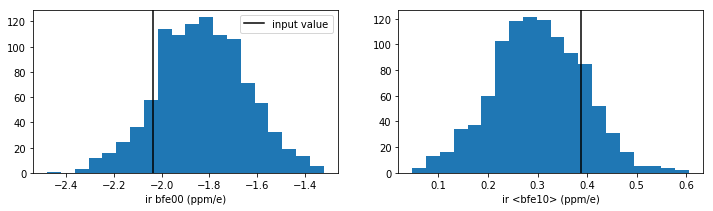

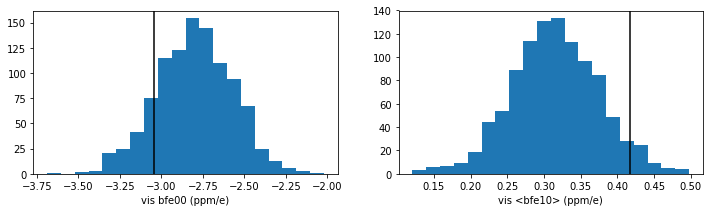

In [20]:
# Showing distributions over the super pixels
# central value, nearest neighbor averaged
bfe00 = 1.E6*ir_data[:,25].copy()
bfenn = np.array((ir_data[:,20], ir_data[:,24], ir_data[:,26], ir_data[:,30]))
avg_bfenn = 1.E6*np.mean(bfenn, axis=0)
# for the vis BFE
visbfe00 = 1.E6*vis_data[:,12].copy()
visbfenn = np.array((vis_data[:,7], vis_data[:,11], vis_data[:,13], vis_data[:,17]))
avg_visbfenn = 1.E6*np.mean(visbfenn, axis=0)

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 3) # (w, h)

# IR first
plt.subplot(121)
plt.hist(bfe00, 20)
plt.axvline(-2.0356, color='k', label='input value')
plt.xlabel('ir bfe00 (ppm/e)')
plt.legend(loc='best')
plt.subplot(122)
plt.hist(avg_bfenn, 20)
plt.axvline(0.388625, color='k')
plt.xlabel('ir <bfe10> (ppm/e)')

# compared to visible
plt.figure()
plt.subplot(121)
plt.hist(visbfe00, 20)
plt.axvline(-3.0462, color='k')
plt.xlabel('vis bfe00 (ppm/e)')
plt.subplot(122)
plt.hist(avg_visbfenn, 20)
plt.axvline(0.4176, color='k')
plt.xlabel('vis <bfe10> (ppm/e)')

plt.show()

In [21]:
# check omega, input was 0.08
# cxx, cxy, cyy inputs were 0.04, 0.02, 0.04
omega = vis_data[:,50].copy()
cxx = vis_data[:,51].copy()
cxy = vis_data[:,52].copy()
cyy = vis_data[:,53].copy()
print(omega.mean())
print(cxx.mean())
print(cxy.mean())
print(cyy.mean())

0.08069969796445776
0.04046841840607185
0.019734011760279127
0.0413975196622804
